In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import cv2


import os
import sys
sys.path.append(os.path.join(os.getcwd(), '..'))

from lib_MHDPIC1D.pic1d import *
from lib_MHDPIC1D.mhd1d import *
from lib_MHDPIC1D.interface import *
from lib_MHDPIC1D.remove_noise import *

In [6]:
def boundary_Poynting_flux(speed_ratio, VA, B0, rho_init, p_init, gamma, U):
    U[0, :2] = rho_init[:2] * (1.0 + speed_ratio)
    U[1, :2] = rho_init[:2] * speed_ratio * VA
    U[2, :2] = 0.0
    U[3, :2] = 0.0
    U[4, :2] = 0.1 * B0
    U[5, :2] = -B0 * (1.0 + speed_ratio)
    U[6, :2] = 0.0
    p = p_init[:2] * (1.0 + gamma * speed_ratio)
    U[7, :2] = p / (gamma - 1.0) \
            + 0.5 * rho_init[:2] * (1.0 + speed_ratio) * (speed_ratio * VA)**2 \
            + 0.5 * (B0 * (1.0 + speed_ratio))**2
    
    U[0, -2:] = rho_init[-2:] * (1.0 + speed_ratio)
    U[1, -2:] = -rho_init[-2:] * speed_ratio * VA
    U[2, -2:] = 0.0
    U[3, -2:] = 0.0
    U[4, -2:] = 0.1 * B0
    U[5, -2:] = B0 * (1.0 + speed_ratio)
    U[6, -2:] = 0.0
    p = p_init[0] * (1.0 + gamma * speed_ratio)
    U[7, -2:] = p / (gamma - 1.0) \
            + 0.5 * rho_init[-2:] * (1.0 + speed_ratio) * (speed_ratio * VA)**2 \
            + 0.5 * (B0 * (1.0 + speed_ratio))**2

    return U

カレントシート with Poynting flux MHDのみ

In [7]:
c = 1.0
mu_0 = 1.0
epsilon0 = 1.0 / (mu_0 * c**2)
m_electron = 1.0
r_m = 1 / 100
m_ion = m_electron / r_m
t_r = 1.0
ne0_pic = 100 #ここは手動で調整すること
ni0_pic = ne0_pic
B0_pic = np.sqrt(ne0_pic) / 1.0 / np.sqrt(2/(1+t_r))
Ti_pic  = (B0_pic**2 / 2.0 / mu_0) / (ni0_pic + ne0_pic * t_r)
Te_pic = Ti_pic * t_r
q_electron = -1 * np.sqrt(epsilon0 * Te_pic / ne0_pic)
q_ion = -1 * q_electron
debye_length = np.sqrt(epsilon0 * Te_pic / ne0_pic / q_electron**2)
omega_pe = np.sqrt(ne0_pic * q_electron**2 / m_electron / epsilon0)
omega_pi = np.sqrt(ni0_pic * q_ion**2 / m_ion / epsilon0)
omega_ce = q_electron * B0_pic / m_electron
omega_ci = q_ion * B0_pic / m_ion
VA_pic = B0_pic / np.sqrt(ni0_pic * m_ion + ni0_pic * m_electron)
gamma_pic = 5.0 / 3.0
rho_pic = ni0_pic * m_ion + ne0_pic * m_electron
p_pic = ni0_pic * Ti_pic + ne0_pic * Te_pic
CS_pic = np.sqrt(gamma_pic * p_pic / rho_pic)
ion_inertial_length = c / omega_pi
sheat_thickness_pic = 3.0 * ion_inertial_length
v_electron = np.array([0.0, 0.0, -c * debye_length / sheat_thickness_pic * np.sqrt(2 / (1.0 + 1/t_r))])
v_ion = -v_electron / t_r
v_thermal_electron = np.sqrt(2.0 * Te_pic / m_electron)
v_thermal_ion = np.sqrt(2.0 * Ti_pic / m_ion)
v_thermal_electron_background = np.sqrt(2.0 * 0.2 * Te_pic / m_electron)
v_thermal_ion_background = np.sqrt(2.0 * 0.2 * Ti_pic / m_ion)

dx_pic = debye_length
nx_pic = int(40 * ion_inertial_length)
x_min_pic = 1e-10
x_max_pic = nx_pic * dx_pic - 1e-10
x_coordinate_pic = np.arange(0.0, x_max_pic, dx_pic)
dt_pic = 0.0
d_pic = 0.0

E_pic = np.zeros([3, nx_pic])
B_pic = np.zeros([3, nx_pic])
current_pic = np.zeros([3, nx_pic])
rho_pic = np.zeros(nx_pic)
B_pic[1, :] = B0_pic * np.tanh((x_coordinate_pic - nx_pic/2.0) / sheat_thickness_pic)
beta_pic = (ne0_pic * Te_pic + ni0_pic * Ti_pic) / (B0_pic**2 / 2 / mu_0)

n_ion = int(ni0_pic * 2.0 * sheat_thickness_pic)
n_electron = int(n_ion * abs(q_ion / q_electron))
n_ion_background = int(0.2 * ni0_pic * x_max_pic)
n_electron_background = int(0.2 * ne0_pic * x_max_pic)

MHD初期化 \
U1は上半分、U2は下半分のつもり

In [8]:
gamma_mhd = 5.0 / 3.0
B0_mhd = B0_pic
rho0_mhd = ne0_pic * m_electron + ni0_pic * m_ion
p0_mhd = ne0_pic * Te_pic + ni0_pic * Ti_pic
VA_mhd = B0_mhd / np.sqrt(rho0_mhd)
CS_mhd = np.sqrt(gamma_mhd * p0_mhd / rho0_mhd)
Cf_mhd = np.sqrt(VA_mhd**2 + CS_mhd**2)
dx_mhd = dx_pic

nx_mhd = 1700
x_min_mhd = 1e-10
x_max_mhd = nx_mhd * dx_mhd - 1e-10
dt_mhd = 0.0
CFL = 0.7
x_coordinate_mhd = np.arange(x_min_mhd, x_max_mhd, dx_mhd)

sheat_thickness_mhd = sheat_thickness_pic / dx_pic * dx_mhd
speed_ratio = 0.05

U1 = np.zeros([8, nx_mhd])
rho_init = rho0_mhd * (0.2 + 1.0 / np.cosh((x_coordinate_mhd - nx_mhd/2.0) / sheat_thickness_mhd)**2)
u_init = 0.0
v_init = 0.0
w_init = 0.0
Bx_init = 0.1 * B0_mhd
By_init = B0_mhd * np.tanh((x_coordinate_mhd - nx_mhd/2.0) / sheat_thickness_mhd)
Bz_init = 0.0
p_init = p0_mhd * (0.2**2 + 1.0 / np.cosh((x_coordinate_mhd - nx_mhd/2.0) / sheat_thickness_mhd)**2)
U1[0, :] = rho_init
U1[1, :] = rho_init * u_init
U1[2, :] = rho_init * v_init
U1[3, :] = rho_init * w_init
U1[4, :] = Bx_init
U1[5, :] = By_init
U1[6, :] = Bz_init
U1[7, :] = p_init / (gamma_mhd - 1) + rho_init * (u_init**2 + v_init**2 + w_init**2)/2 + (Bx_init**2 + By_init**2 + Bz_init**2)/2

flux1 = np.zeros(U1.shape)
flux1_bar = np.zeros(flux1.shape)

print(f"U1 size = {U1.shape}")

U1 size = (8, 1700)


時間発展

In [9]:
steps = 3000
time_mhd = 0.0

for step in range(steps+1):

    # save
    if (step % 10 == 0):
        print(f"{step} step done... : time_mhd = {time_mhd:.5f}, dt_mhd = {dt_mhd:.5f}")
        np.save(f"./results_MHD_current_sheet_Bx/U1_{step}.npy", U1)

    #MHD
    #----------------------------------------------------------- 

    U1_bar = U1.copy()

    rho_mhd = U1[0, :]
    u_mhd = U1[1, :] / rho_mhd
    v_mhd = U1[2, :] / rho_mhd
    w_mhd = U1[3, :] / rho_mhd
    Bx_mhd = U1[4, :]
    By_mhd = U1[5, :]
    Bz_mhd = U1[6, :]
    e_mhd = U1[7, :]
    p_mhd = (gamma_mhd - 1.0) \
        * (e_mhd - 0.5 * rho_mhd * (u_mhd**2+v_mhd**2+w_mhd**2)
            - 0.5 * (Bx_mhd**2+By_mhd**2+Bz_mhd**2))
    flux1 = get_flux_HLLD(rho_mhd, u_mhd, v_mhd, w_mhd, Bx_mhd, By_mhd, Bz_mhd, e_mhd, gamma_mhd, flux1, axis=0)

    cs_mhd = np.sqrt(gamma_mhd * p_mhd / rho_mhd)
    ca_mhd = np.sqrt((Bx_mhd**2 + By_mhd**2 + Bz_mhd**2) / rho_mhd)
    dt_mhd = CFL * np.min(1.0 / ((np.abs(u_mhd) + np.sqrt(cs_mhd**2 + ca_mhd**2)) / dx_mhd))
    if np.isnan(time_mhd):
        print(f"{step} steps (t = {time_mhd:.3f}) : Calculation is crashed!")
        break
    
    U1_bar += -dt_mhd/dx_mhd * (flux1 - np.roll(flux1, 1, axis=1))
    U1_bar = boundary_Poynting_flux(speed_ratio * (1.0 + np.tanh(((step-200)/50)))/2.0, VA_mhd, B0_mhd, rho_init, p_init, gamma_mhd, U1_bar)
    
    rho_mhd = U1_bar[0, :]
    u_mhd = U1_bar[1, :] / rho_mhd
    v_mhd = U1_bar[2, :] / rho_mhd
    w_mhd = U1_bar[3, :] / rho_mhd
    Bx_mhd = U1_bar[4, :]
    By_mhd = U1_bar[5, :]
    Bz_mhd = U1_bar[6, :]
    e_mhd = U1_bar[7, :]
    p_mhd = (gamma_mhd - 1.0) \
        * (e_mhd - 0.5 * rho_mhd * (u_mhd**2+v_mhd**2+w_mhd**2)
            - 0.5 * (Bx_mhd**2+By_mhd**2+Bz_mhd**2))
    flux1_bar = get_flux_HLLD(rho_mhd, u_mhd, v_mhd, w_mhd, Bx_mhd, By_mhd, Bz_mhd, e_mhd, gamma_mhd, flux1_bar, axis=0)
    flux1 = 0.5 * (flux1 + flux1_bar)

    U1 += -dt_mhd/dx_mhd * (flux1 - np.roll(flux1, 1, axis=1))
    U1 = boundary_Poynting_flux(speed_ratio * (1.0 + np.tanh(((step-200)/50)))/2.0, VA_mhd, B0_mhd, rho_init, p_init, gamma_mhd, U1)
    
    time_mhd += dt_mhd

0 step done... : time_mhd = 0.00000, dt_mhd = 0.00000
10 step done... : time_mhd = 30.77395, dt_mhd = 3.07605
20 step done... : time_mhd = 61.52633, dt_mhd = 3.07459
30 step done... : time_mhd = 92.26480, dt_mhd = 3.07328
40 step done... : time_mhd = 122.99140, dt_mhd = 3.07218
50 step done... : time_mhd = 153.70786, dt_mhd = 3.07123
60 step done... : time_mhd = 184.41575, dt_mhd = 3.07044
70 step done... : time_mhd = 215.11645, dt_mhd = 3.06979
80 step done... : time_mhd = 245.81129, dt_mhd = 3.06926
90 step done... : time_mhd = 276.50157, dt_mhd = 3.06886
100 step done... : time_mhd = 307.18857, dt_mhd = 3.06852
110 step done... : time_mhd = 337.86973, dt_mhd = 3.06782
120 step done... : time_mhd = 368.54522, dt_mhd = 3.06737
130 step done... : time_mhd = 399.21776, dt_mhd = 3.06683
140 step done... : time_mhd = 429.86268, dt_mhd = 3.06240
150 step done... : time_mhd = 460.45611, dt_mhd = 3.05660
160 step done... : time_mhd = 490.98258, dt_mhd = 3.04919
170 step done... : time_mhd = 

プロット

In [10]:
k = 1000

U = np.load(f"results_MHD_current_sheet_Bx/U1_{k}.npy")
rho_mhd = U[0, :]
u_mhd = U[1, :] / rho_mhd
v_mhd = U[2, :] / rho_mhd
w_mhd = U[3, :] / rho_mhd
Bx_mhd = U[4, :]
By_mhd = U[5, :]
Bz_mhd = U[6, :]
e_mhd = U[7, :]
p_mhd = (gamma_mhd - 1.0) \
        * (e_mhd - 0.5 * rho_mhd * (u_mhd**2+v_mhd**2+w_mhd**2)
            - 0.5 * (Bx_mhd**2+By_mhd**2+Bz_mhd**2))
Ex_mhd = -(v_mhd * Bz_mhd - w_mhd * By_mhd)
Ey_mhd = -(w_mhd * Bx_mhd - u_mhd * Bz_mhd)
Ez_mhd = -(u_mhd * By_mhd - v_mhd * Bx_mhd)
current_x_mhd = np.zeros(Bx_mhd.shape)
current_y_mhd = -(np.roll(Bz_mhd, -1, axis=0) - np.roll(Bz_mhd, 1, axis=0)) / (2*dx_mhd)
current_z_mhd = (np.roll(By_mhd, -1, axis=0) - np.roll(By_mhd, 1, axis=0)) / (2*dx_mhd)
current_y_mhd[0] = current_y_mhd[1] 
current_y_mhd[-1] = current_y_mhd[-2] 
current_z_mhd[0] = current_z_mhd[1] 
current_z_mhd[-1] = current_z_mhd[-2] 

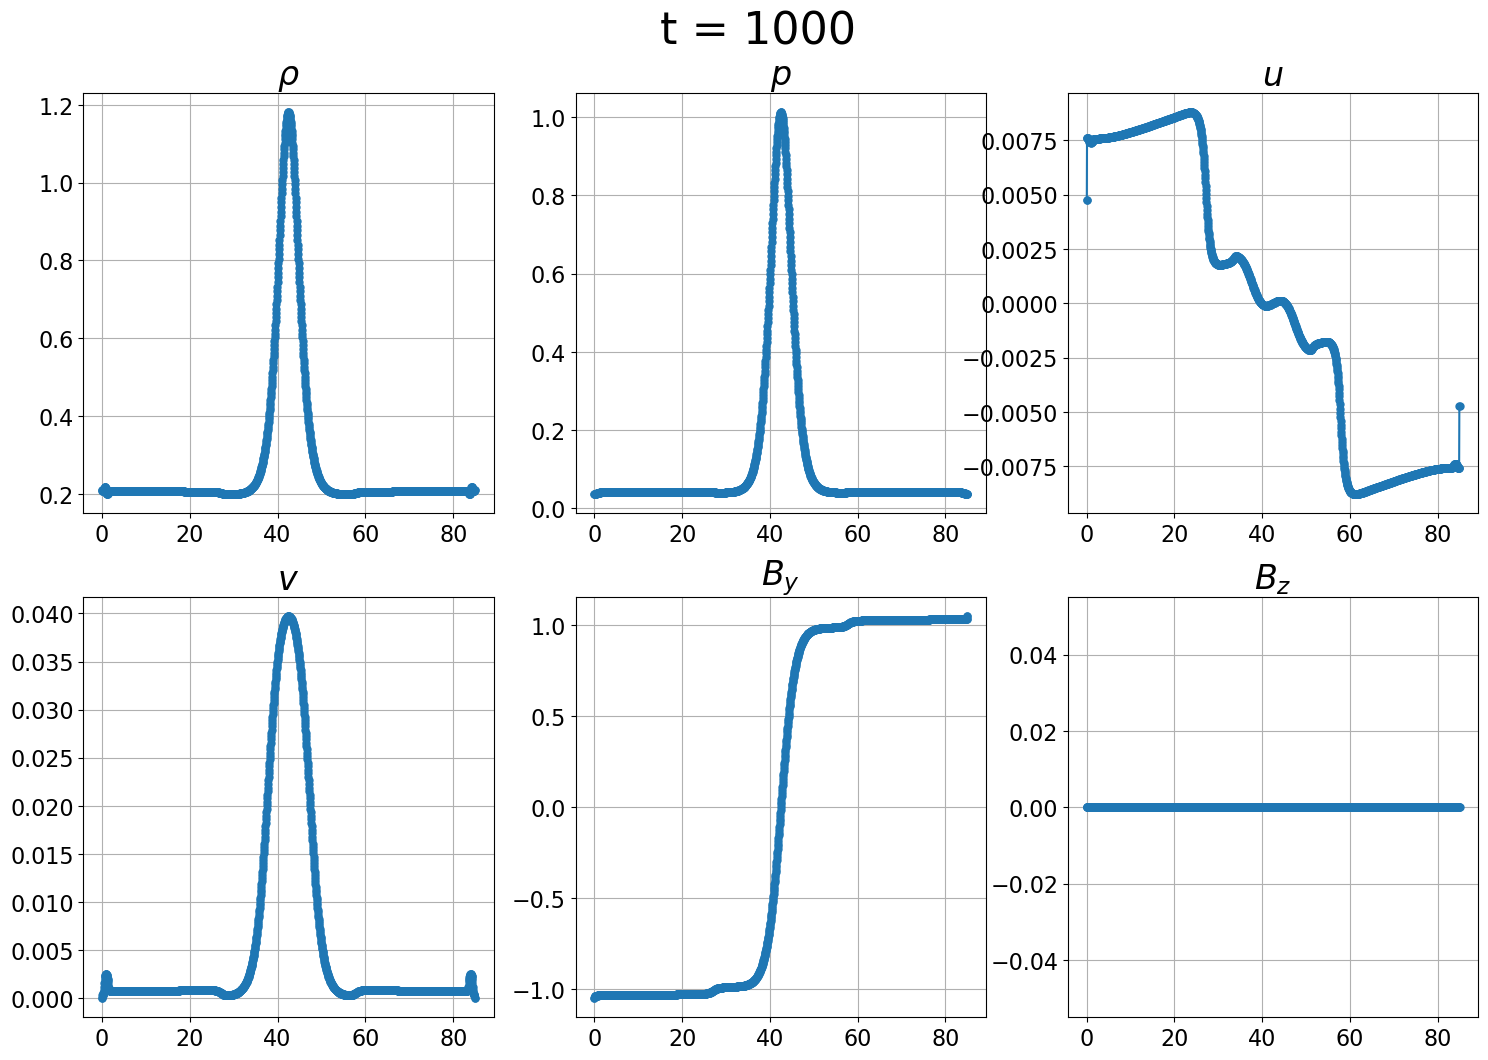

In [11]:
fig = plt.figure(figsize=(18, 12))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
ax6 = fig.add_subplot(236)

rho = U[0, :]
u = U[1, :] / rho 
v = U[2, :] / rho 
w = U[3, :] / rho 
Bx = U[4, :]
By = U[5, :]
Bz = U[6, :]
e = U[7, :]
p = (gamma_mhd-1) * (e - rho*(u**2+v**2+w**2)/2 - (Bx**2+By**2+Bz**2)/2)

ax1.plot(x_coordinate_mhd/ion_inertial_length, rho / rho0_mhd, marker='o', markersize=5)
ax2.plot(x_coordinate_mhd/ion_inertial_length, p / p0_mhd, marker='o', markersize=5)
ax3.plot(x_coordinate_mhd/ion_inertial_length, u, marker='o', markersize=5)
ax4.plot(x_coordinate_mhd/ion_inertial_length, v, marker='o', markersize=5)
ax5.plot(x_coordinate_mhd/ion_inertial_length, By / B0_mhd, marker='o', markersize=5)
ax6.plot(x_coordinate_mhd/ion_inertial_length, Bz / B0_mhd, marker='o', markersize=5)

ax1.set_title(r"$\rho$", fontsize=24)
ax2.set_title(r"$p$", fontsize=24)
ax3.set_title(r"$u$", fontsize=24)
ax4.set_title(r"$v$", fontsize=24)
ax5.set_title(r"$B_y$", fontsize=24)
ax6.set_title(r"$B_z$", fontsize=24)
ax1.tick_params(labelsize=16)
ax2.tick_params(labelsize=16)
ax3.tick_params(labelsize=16)
ax4.tick_params(labelsize=16)
ax5.tick_params(labelsize=16)
ax6.tick_params(labelsize=16)
ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
ax5.grid()
ax6.grid()

plt.suptitle(f"t = {k}", y=0.95, fontsize=32)

plt.show()

動画作成

In [12]:
fig = plt.figure(figsize=(18, 12))
ax1 = fig.add_subplot(411)
ax2 = fig.add_subplot(412)
ax3 = fig.add_subplot(413)
ax4 = fig.add_subplot(414)

filename = "current_sheet_Bx_MHD.mp4"

interval = 10
plot_steps = steps
for i in range(0, plot_steps+1, interval):
    ax1.clear()
    ax2.clear()
    ax3.clear()
    ax4.clear()

    U = np.load(f"results_MHD_current_sheet_Bx/U1_{i}.npy")
    rho = U[0, :]
    u = U[1, :] / rho 
    v = U[2, :] / rho 
    w = U[3, :] / rho 
    Bx = U[4, :]
    By = U[5, :]
    Bz = U[6, :]
    e = U[7, :]
    p = (gamma_mhd-1) * (e - rho*(u**2+v**2+w**2)/2 - (Bx**2+By**2+Bz**2)/2)
    Ex = -(v * Bz - w * Bx)
    Ey = -(w * Bx - u * Bz)
    Ez = -(u * By - v * Bx)
    current_x = np.zeros(Bx.shape)
    current_y = -(np.roll(Bz, -1, axis=0) - np.roll(Bz, 1, axis=0)) / (2*dx_mhd)
    current_z = (np.roll(By, -1, axis=0) - np.roll(By, 1, axis=0)) / (2*dx_mhd)
    current_y[0] = current_y[1] 
    current_y[-1] = current_y[-2] 
    current_z[0] = current_z[1] 
    current_z[-1] = current_z[-2] 

    ax1.plot(x_coordinate_mhd/ion_inertial_length, rho / 0.2 / rho0_mhd, lw=3)
    ax2.plot(x_coordinate_mhd/ion_inertial_length, current_z / B0_mhd / ion_inertial_length, lw=3)
    ax3.plot(x_coordinate_mhd/ion_inertial_length, By / B0_mhd, lw=3)
    ax4.plot(x_coordinate_mhd/ion_inertial_length, Ez / VA_mhd / B0_mhd, lw=3)
    
    ax1.set_xlim(0, nx_mhd*dx_mhd/ion_inertial_length)
    ax2.set_xlim(0, nx_mhd*dx_mhd/ion_inertial_length)
    ax3.set_xlim(0, nx_mhd*dx_mhd/ion_inertial_length)
    ax4.set_xlim(0, nx_mhd*dx_mhd/ion_inertial_length)
    ax1.set_ylim(0.0, 8.0)
    ax2.set_ylim(-0.005, 0.005)
    ax3.set_ylim(-2.0, 2.0)
    ax4.set_ylim(-1.0, 2.0)

    ax4.set_xlabel(r"$x / \lambda_i$", fontsize=24)
    ax1.set_ylabel(r"$\rho / \rho_0$", fontsize=24)
    ax2.set_ylabel(r"$j_z / B_0 / \lambda_i$", fontsize=24)
    ax3.set_ylabel(r"$B_y / B_0$", fontsize=24)
    ax4.set_ylabel(r"$E_z / V_A / B_0$", fontsize=24)
    ax1.tick_params(labelsize=16)
    ax2.tick_params(labelsize=16)
    ax3.tick_params(labelsize=16)
    ax4.tick_params(labelsize=16)
    ax1.grid()
    ax2.grid()
    ax3.grid()
    ax4.grid()

    plt.suptitle(f"t = {i}", y=0.95, fontsize=32)

    fig.savefig(f'./pictures/{i}.png', dpi=200)


img = cv2.imread(f'./pictures/0.png')
framesize = (img.shape[1], img.shape[0])
fps = 5.0

fourcc = cv2.VideoWriter_fourcc('m','p','4','v')
video  = cv2.VideoWriter(filename=filename, fourcc=fourcc, fps=fps, frameSize=framesize)

for i in range(0, plot_steps+1, interval):
    img = cv2.imread(f'./pictures/{i}.png')
    video.write(img)
video.release()